In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc

import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import transforms

from utils import *
from model import get_model

from sklearn.metrics import roc_auc_score, confusion_matrix
from torchvision.ops import sigmoid_focal_loss
from torch.nn.functional import binary_cross_entropy_with_logits

c:\Users\dm\miniconda3\envs\frost\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\dm\miniconda3\envs\frost\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [8]:
# ====== 실험 설정 ====== # 중요함
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# 사용할 데이터 종류 설정, 단일 학습인지 멀티테스크인지 설정 (URP 에서 AAFOS FALSE 설정)
ASOS = True
AAFOS = False
assert ASOS or AAFOS, "At least one of ASOS or AAFOS must be True."

channels = '16ch' # '16ch' or 'ae304', 16ch일때 [16,512,512]
time_range = [-12]
resolution = '2km' # '1km':1024 or '2km':512
postfix = 'baseline_prediction_192'

output_path = "results/"
output_path += 'asos_' if ASOS else ''
output_path += 'aafos_' if AAFOS else ''
output_path += channels + '_'
output_path += 'time' + str(time_range) + '_'
output_path += resolution
output_path += ('_' + postfix) if postfix != '' else postfix
print(f"Output path name: {output_path}")

# 기본 asos:aafos 비율 5:1
asos_aafos_ratio = 5.0
asos_weight = asos_aafos_ratio / (asos_aafos_ratio + 1.0 * AAFOS) if ASOS else 0.0
aafos_weight = 1.0 / (asos_aafos_ratio * ASOS + 1.0) if AAFOS else 0.0
print(f"ASOS weight: {asos_weight:.2f}, AAFOS weight: {aafos_weight:.2f}")

# 기타 ablation 설정
latlon = False

# 실험중인 설정들
central_patch = False
use_patch = False

#  ====== 채널 설정 ====== #
if channels == '16ch':
    channels_name = ['vi004','vi005','vi006','vi008','nr013','nr016','sw038','wv063','wv069','wv073','ir087','ir096','ir105','ir112','ir123','ir133'] # 시각화 용
    channels_calib = ['vi004','vi005','vi006','vi008','nr013','nr016','sw038','wv063','wv069','wv073','ir087','ir096','ir105','ir112','ir123','ir133']
    
    channels_mean = [1.1912e-01, 1.1464e-01, 1.0734e-01, 1.2504e-01, 5.4983e-02, 9.0381e-02,
                2.7813e+02, 2.3720e+02, 2.4464e+02, 2.5130e+02, 2.6948e+02, 2.4890e+02,
                2.7121e+02, 2.7071e+02, 2.6886e+02, 2.5737e+02]
    channels_std  = [0.1306,  0.1303,  0.1306,  0.1501,  0.0268,  0.0838, 15.8211,  6.1468,
                7.8054,  9.3251, 16.4265,  9.6150, 17.2518, 17.6064, 17.0090, 12.5026]

else:
    raise ValueError("Invalid channels.")


train_data_info_list = []
train_data_info_list.append({
    'label_type': 'asos', # 'asos' or 'aafos'
    'start_date_str': '20200101', #  라벨기준 일자. KST
    'end_date_str': '20230630',
    'hour_col_pairs': [(6,'AM')],
    'label_keys': ['93','108','112','119','131','133','136','143','146','156','177','102','104','115','138','152','155','159','165','168','169','184','189']
}) if ASOS else None

test_asos_data_info_list = [
    {
        'label_type': 'asos', # 'asos' or 'aafos'
        'start_date_str': '20230701', #  라벨기준 일자. KST
        'end_date_str': '20240630',
        'hour_col_pairs': [(6,'AM')],
        'label_keys': ['93','108','112','119','131','133','136','143','146','156','177','102','104','115','138','152','155','159','165','168','169','184','189']
    },
] if ASOS else None


origin_size = 900 if resolution == '2km' else 1800
image_size = 192  # 192x192 크기 (512 -> 384 crop -> 192 resize)
patch_size = 192  # 패치 크기

# 512x512 원본 이미지 경로 (GK2ADataset에서 512->384 crop->192 resize 수행)
data_path = '../data/date_kst_URP'

misc_channels = {
    'elevation':'elevation_1km_3600.npy',
    'vegetation':'vegetation_1km_3600.npy',
    'watermap':'watermap_1km_avg_3600.npy'
}
lat_lon_path = 'assets/gk2a_ami_ko010lc_latlon.nc'

# 학습과 관련된 설정! 변경 시 주의 요함
batch_size = 64
num_workers = 8

epochs = 25
lr = 1e-3
decay = [10, 20]
lr_decay = 0.1
weight_decay = 1e-5
threshold = [0.25]

# 자동으로 설정되는 값 (get_station_map 함수 사용 권장)
asos_x_base, asos_y_base, asos_image_size = get_crop_base(image_size, label_type='asos')
aafos_x_base, aafos_y_base, aafos_image_size = get_crop_base(image_size, label_type='aafos')
aafos_x_base -= asos_x_base
aafos_y_base -= asos_y_base

total_channels = len(channels_name) * len(time_range) + len(misc_channels.keys())
total_channels += 2 if latlon else 0
print(total_channels)

Output path name: results/asos_16ch_time[-12]_2km_baseline_prediction_192
ASOS weight: 1.00, AAFOS weight: 0.00
19


In [9]:
asos_image_size

192

Image size: 192
ASOS station keys: [93, 108, 112, 119, 131, 133, 136, 143, 146, 156, 177, 102, 104, 115, 138, 152, 155, 159, 165, 168, 169, 184, 189]


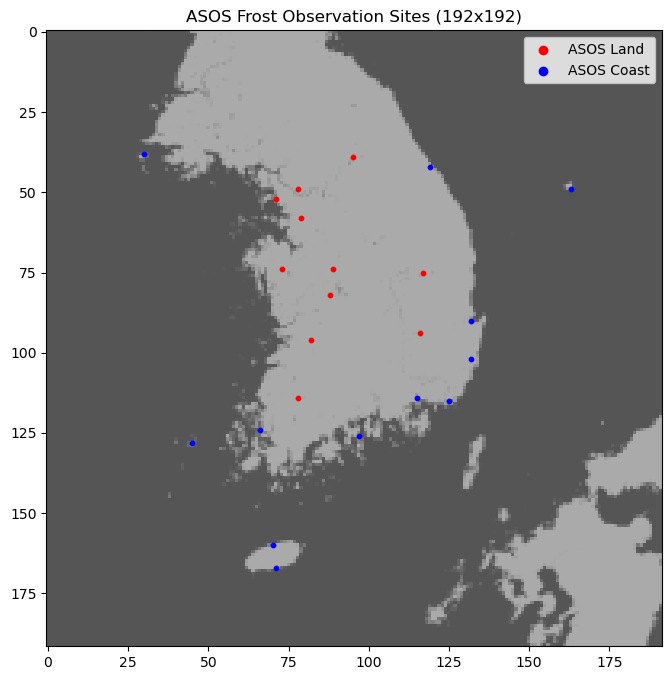

In [12]:
# get_station_map 함수를 사용하여 관측소 좌표 계산 (image_size에 따라 자동 변환)
# - image_size=384: 512에서 (64,64) offset으로 crop한 384x384 좌표
# - image_size=192: 384 좌표를 2로 나눈 값
asos_map_dict = get_station_map(image_size, label_type='asos', origin_size=origin_size)

# Land와 Coast 관측소 분리 (시각화용)
asos_land_keys = list(ASOS_LAND_COORD.keys())
asos_coast_keys = list(ASOS_COAST_COORD.keys())
asos_land_map = {k: v for k, v in asos_map_dict.items() if k in asos_land_keys}
asos_coast_map = {k: v for k, v in asos_map_dict.items() if k in asos_coast_keys}

print(f"Image size: {image_size}")
print(f"ASOS station keys: {list(asos_map_dict.keys())}")

# misc_images 처리: 3600 -> 512 resize -> 384 crop -> 192 resize
CROP_BASE = 64  # 512 -> 384 crop offset
CROP_SIZE_384 = 384

image = np.load('assets/misc_channels/watermap_1km_avg_3600.npy', allow_pickle=True)
image = -image + 1.0
image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_CUBIC)
if image_size == 384 or image_size == 192:
    image = image[CROP_BASE:CROP_BASE+CROP_SIZE_384, CROP_BASE:CROP_BASE+CROP_SIZE_384]  # 384x384로 crop
    if image_size == 192:
        image = cv2.resize(image, (image_size, image_size), interpolation=cv2.INTER_AREA)  # 384 -> 192로 resize

plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray', vmin=-1, vmax=2)

for k, v in asos_land_map.items():
    plt.scatter(v[0], v[1], c='r', marker='o', s=10)
for k, v in asos_coast_map.items():
    plt.scatter(v[0], v[1], c='b', marker='o', s=10)

plt.scatter([], [], c='r', marker='o', label='ASOS Land')
plt.scatter([], [], c='b', marker='o', label='ASOS Coast')

plt.title(f'ASOS Frost Observation Sites ({image_size}x{image_size})')
plt.legend()
plt.show()

In [14]:
if channels_mean is None:
    date_list = os.listdir(data_path)
    date_list = [date for date in date_list if '20200101' <= date < '20240101']

    npy_list = []
    for date in tqdm(date_list[::10]):
        for file in os.listdir(os.path.join(data_path, date)):
            if channels not in file:
                continue
            npy = np.load(os.path.join(data_path, date, file), allow_pickle=True).astype(np.float32) # (C, H, W)
            npy_list.append(npy)
    npy_array = np.stack(npy_list, axis=0)
    print(npy_array.shape) # (N, C, H, W)

    channels_mean = npy_array.mean(axis=(0,2,3)).tolist()
    channels_std = npy_array.std(axis=(0,2,3)).tolist()

channels_mean = channels_mean * len(time_range)
channels_std = channels_std * len(time_range)

print(channels_mean)
print(channels_std)

[0.11912, 0.11464, 0.10734, 0.12504, 0.054983, 0.090381, 278.13, 237.2, 244.64, 251.3, 269.48, 248.9, 271.21, 270.71, 268.86, 257.37]
[0.1306, 0.1303, 0.1306, 0.1501, 0.0268, 0.0838, 15.8211, 6.1468, 7.8054, 9.3251, 16.4265, 9.615, 17.2518, 17.6064, 17.009, 12.5026]


In [15]:
lat_lon_data = nc.Dataset(lat_lon_path)
lat = lat_lon_data['lat'][:].data
lon = lat_lon_data['lon'][:].data

lat = cv2.resize(lat, (origin_size, origin_size), interpolation=cv2.INTER_CUBIC)
lon = cv2.resize(lon, (origin_size, origin_size), interpolation=cv2.INTER_CUBIC)
print(lat.shape, lon.shape)

# lat/lon 처리: origin_size에서 384 영역 crop 후 image_size로 resize
CROP_SIZE_384 = 384

# 384 영역 crop (asos_x_base, asos_y_base는 384 기준 좌표)
asos_lat_384 = lat[asos_y_base:asos_y_base+CROP_SIZE_384, asos_x_base:asos_x_base+CROP_SIZE_384]
asos_lon_384 = lon[asos_y_base:asos_y_base+CROP_SIZE_384, asos_x_base:asos_x_base+CROP_SIZE_384]

# image_size에 따라 resize
if image_size == 192:
    asos_lat = cv2.resize(asos_lat_384.astype(np.float32), (image_size, image_size), interpolation=cv2.INTER_AREA)
    asos_lon = cv2.resize(asos_lon_384.astype(np.float32), (image_size, image_size), interpolation=cv2.INTER_AREA)
else:
    asos_lat = asos_lat_384.astype(np.float32)
    asos_lon = asos_lon_384.astype(np.float32)
print(f'asos_lat shape: {asos_lat.shape}, asos_lon shape: {asos_lon.shape}')

lcc = ccrs.LambertConformal(central_longitude=126, central_latitude=38, standard_parallels = (30,60))
proj = ccrs.PlateCarree()

(900, 900) (900, 900)
asos_lat shape: (192, 192), asos_lon shape: (192, 192)


MISC images shape: torch.Size([3, 192, 192])
Total mean: [0.11912, 0.11464, 0.10734, 0.12504, 0.054983, 0.090381, 278.13, 237.2, 244.64, 251.3, 269.48, 248.9, 271.21, 270.71, 268.86, 257.37, 74.05298614501953, 0.1491597592830658, 0.7218806743621826]
Total std: [0.1306, 0.1303, 0.1306, 0.1501, 0.0268, 0.0838, 15.8211, 6.1468, 7.8054, 9.3251, 16.4265, 9.615, 17.2518, 17.6064, 17.009, 12.5026, 175.26022338867188, 0.2751089036464691, 0.4365760385990143]


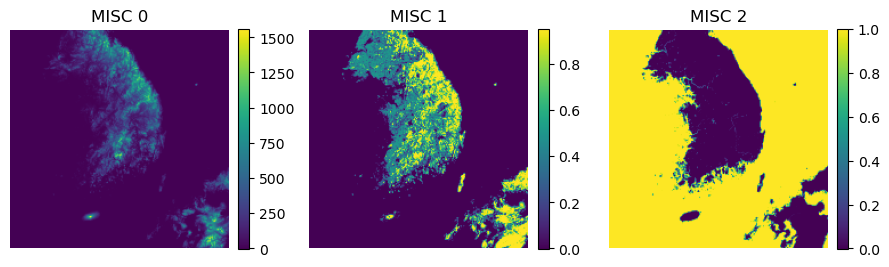

In [16]:
"""
MISC 0: Elevation (고도)
MISC 1: Water Bodies Index (수역 여부)
MISC 2: Vegetation Index (식생 여부)

처리 경로: 3600 -> 512 resize -> 384 crop -> (192 resize if image_size==192)
"""
CROP_BASE = 64  # 512 -> 384 crop offset
CROP_SIZE_384 = 384

misc_images = []
for misc_channel, misc_path in misc_channels.items():
    misc_image = np.load(f'assets/misc_channels/{misc_path}', allow_pickle=True)
    # 3600 -> 512로 resize
    misc_image = cv2.resize(misc_image, (512, 512), interpolation=cv2.INTER_CUBIC)
    # 512 -> 384 crop (위성 이미지와 동일한 영역)
    misc_image = misc_image[CROP_BASE:CROP_BASE+CROP_SIZE_384, CROP_BASE:CROP_BASE+CROP_SIZE_384]
    # image_size가 192인 경우 384 -> 192 resize
    if image_size == 192:
        misc_image = cv2.resize(misc_image, (image_size, image_size), interpolation=cv2.INTER_AREA)
    misc_images.append(misc_image)
misc_images = np.stack(misc_images, axis=0)
misc_images = torch.tensor(misc_images, dtype=torch.float32)

if latlon:
    lat_image = cv2.resize(asos_lat, (asos_image_size, asos_image_size), interpolation=cv2.INTER_CUBIC)
    lon_image = cv2.resize(asos_lon, (asos_image_size, asos_image_size), interpolation=cv2.INTER_CUBIC)
    
    lat_image = torch.tensor(lat_image, dtype=torch.float32).unsqueeze(0)
    lon_image = torch.tensor(lon_image, dtype=torch.float32).unsqueeze(0)
    misc_images = torch.cat([misc_images, lat_image, lon_image], dim=0)

print(f'MISC images shape: {misc_images.shape}')

# normalize by channel
misc_mean = misc_images.mean(dim=[1,2], keepdim=True)
misc_std = misc_images.std(dim=[1,2], keepdim=True)

total_mean = channels_mean + misc_mean.squeeze().tolist()
total_std = channels_std + misc_std.squeeze().tolist()

print(f'Total mean: {total_mean}')
print(f'Total std: {total_std}')

fig, axs = plt.subplots(math.ceil(misc_images.shape[0]/3), 3, figsize=(9, 5))
for i in range(misc_images.shape[0]):
    ax = axs.flatten()[i]
    ax.imshow(misc_images[i].numpy(), cmap='viridis')
    ax.set_title(f'MISC {i}')
    colorbar = plt.colorbar(mappable=ax.images[0], ax=ax, fraction=0.046, pad=0.04)
    ax.axis('off')
for i in range(misc_images.shape[0], len(axs.flatten())):
    ax = axs.flatten()[i]
    ax.axis('off')
plt.tight_layout()
plt.show()

ASOS patch candidates: [[0 0]]


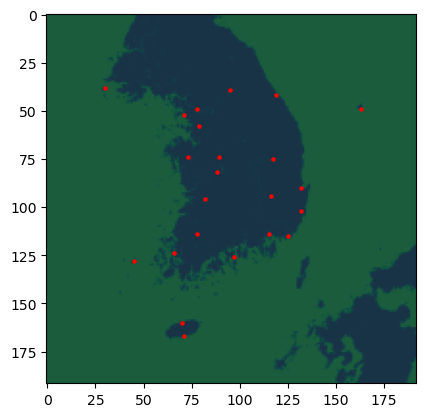

In [17]:
asos_patch_candidate = np.zeros([image_size, image_size], dtype=np.uint8)
for x, y in asos_map_dict.values():
    y_min = np.clip(y - 3*patch_size//4, 0, image_size - patch_size+1)
    y_max = np.clip(y - patch_size//4, 0, image_size - patch_size+1)   
    x_min = np.clip(x - 3*patch_size//4, 0, image_size - patch_size+1)
    x_max = np.clip(x - patch_size//4, 0, image_size - patch_size+1)
    asos_patch_candidate[y_min:y_max, x_min:x_max] = 1
    plt.scatter(x, y, c='r', marker='o', s=5)
plt.imshow(misc_images[2], cmap='viridis', vmin=-1, vmax=2)
plt.imshow(asos_patch_candidate, cmap='gray', vmin=0, vmax=1, alpha=0.5)
asos_patch_candidate = np.argwhere(asos_patch_candidate == 1)[:, [1, 0]]
print(f'ASOS patch candidates: {asos_patch_candidate}')
plt.show()


patch_candidates = {
    'asos': asos_patch_candidate}

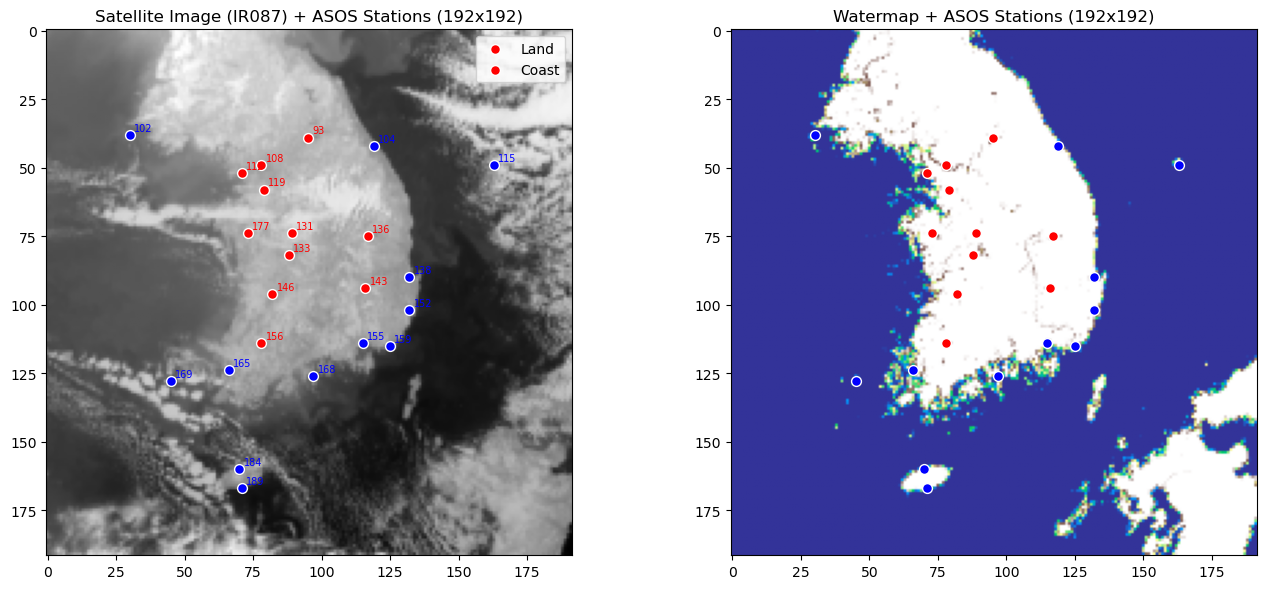


=== ASOS 좌표 범위 검증 (192x192) ===
X 범위: 30 ~ 163 (이미지: 0~191)
Y 범위: 38 ~ 167 (이미지: 0~191)
범위 내 관측소: 23/23


In [18]:
# === 이미지 + ASOS 좌표 시각적 검증 ===
import numpy as np
import matplotlib.pyplot as plt

# 1. 샘플 위성 이미지 로드 (512x512 원본에서 384 crop -> 192 resize)
sample_date = '20230101'
sample_file = f'{data_path}/{sample_date}/16ch_{sample_date}0600.npy'
sample_image = np.load(sample_file).astype(np.float32)

# 512 -> 384 crop -> 192 resize (GK2ADataset과 동일한 처리)
CROP_BASE = 64
CROP_SIZE_384 = 384

sample_image = sample_image[:, CROP_BASE:CROP_BASE+CROP_SIZE_384, CROP_BASE:CROP_BASE+CROP_SIZE_384]
if image_size == 192:
    sample_image_resized = np.zeros((sample_image.shape[0], 192, 192), dtype=np.float32)
    for i in range(sample_image.shape[0]):
        sample_image_resized[i] = cv2.resize(sample_image[i], (192, 192), interpolation=cv2.INTER_AREA)
    sample_image = sample_image_resized

# 2. IR 채널로 배경 표시
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 좌: 위성 이미지 + ASOS 위치
ax1 = axes[0]
ax1.imshow(sample_image[10], cmap='gray')  # IR087 채널
for k, (x, y) in asos_land_map.items():
    ax1.scatter(x, y, c='red', s=50, edgecolors='white', linewidth=1)
    ax1.annotate(str(k), (x, y), xytext=(3, 3), textcoords='offset points', 
                fontsize=7, color='red')
for k, (x, y) in asos_coast_map.items():
    ax1.scatter(x, y, c='blue', s=50, edgecolors='white', linewidth=1)
    ax1.annotate(str(k), (x, y), xytext=(3, 3), textcoords='offset points', 
                fontsize=7, color='blue')
ax1.set_title(f'Satellite Image (IR087) + ASOS Stations ({image_size}x{image_size})')
ax1.legend(['Land', 'Coast'], loc='upper right')

# 우: 지형 맵(watermap) + ASOS 위치
ax2 = axes[1]
# misc_images[2]가 watermap
watermap = misc_images[2].numpy() if torch.is_tensor(misc_images[2]) else misc_images[2]
ax2.imshow(-watermap + 1, cmap='terrain')
for k, (x, y) in asos_land_map.items():
    ax2.scatter(x, y, c='red', s=50, edgecolors='white', linewidth=1)
for k, (x, y) in asos_coast_map.items():
    ax2.scatter(x, y, c='blue', s=50, edgecolors='white', linewidth=1)
ax2.set_title(f'Watermap + ASOS Stations ({image_size}x{image_size})')

plt.tight_layout()
plt.show()

# 3. 좌표 범위 검증 출력
print(f"\n=== ASOS 좌표 범위 검증 ({image_size}x{image_size}) ===")
all_coords = list(asos_land_map.values()) + list(asos_coast_map.values())
xs = [c[0] for c in all_coords]
ys = [c[1] for c in all_coords]
print(f"X 범위: {min(xs)} ~ {max(xs)} (이미지: 0~{image_size-1})")
print(f"Y 범위: {min(ys)} ~ {max(ys)} (이미지: 0~{image_size-1})")
print(f"범위 내 관측소: {sum(1 for x,y in all_coords if 0<=x<image_size and 0<=y<image_size)}/23")

In [20]:
print(image_size, patch_size)

transform = transforms.Compose([
    transforms.Normalize(mean=total_mean, std=total_std)
])

train_dataset = GK2ADataset(data_path=data_path, output_path=output_path, data_info_list=train_data_info_list,
                            channels=channels, time_range=time_range, channels_calib=channels_calib, image_size=image_size, misc_images=misc_images,
                            patch_size=patch_size, patch_candidates=patch_candidates, transform=transform, train=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

if ASOS:
    test_asos_dataset = GK2ADataset(data_path=data_path, output_path=output_path, data_info_list=test_asos_data_info_list,
                            channels=channels, time_range=time_range, channels_calib=channels_calib, image_size=image_size, misc_images=misc_images,
                            patch_size=patch_size, patch_candidates=None, transform=transform, train=False)
    test_asos_dataloader = DataLoader(test_asos_dataset, batch_size=batch_size//2, shuffle=False, num_workers=num_workers, drop_last=False)


== Preparing asos...



Processing asos:   1%|▎                                            | 9/1277 [00:00<00:14, 86.27it/s]

  - 20200101 AM skipped, 2019-12-31 18:00:00 not in date_table


Processing asos:  50%|████████████████████▉                     | 635/1277 [00:03<00:01, 386.67it/s]

  - 20211003 AM skipped, 2021-10-02 18:00:00 not in date_table


Processing asos: 100%|█████████████████████████████████████████| 1277/1277 [00:08<00:00, 158.84it/s]



  - Total 1275 image-label pairs prepared
  - train_asos_image_label_list.yaml saved

== asos dataset length synced to 1275
GK2A Dataset initialized


== Preparing asos...



Processing asos: 100%|███████████████████████████████████████████| 366/366 [00:03<00:00, 119.90it/s]



  - Total 366 image-label pairs prepared
  - test_asos_image_label_list.yaml saved

== asos dataset length synced to 366
GK2A Dataset initialized




Dataset patchfy set to True.

torch.Size([19, 192, 192]) torch.Size([23]) (2,)


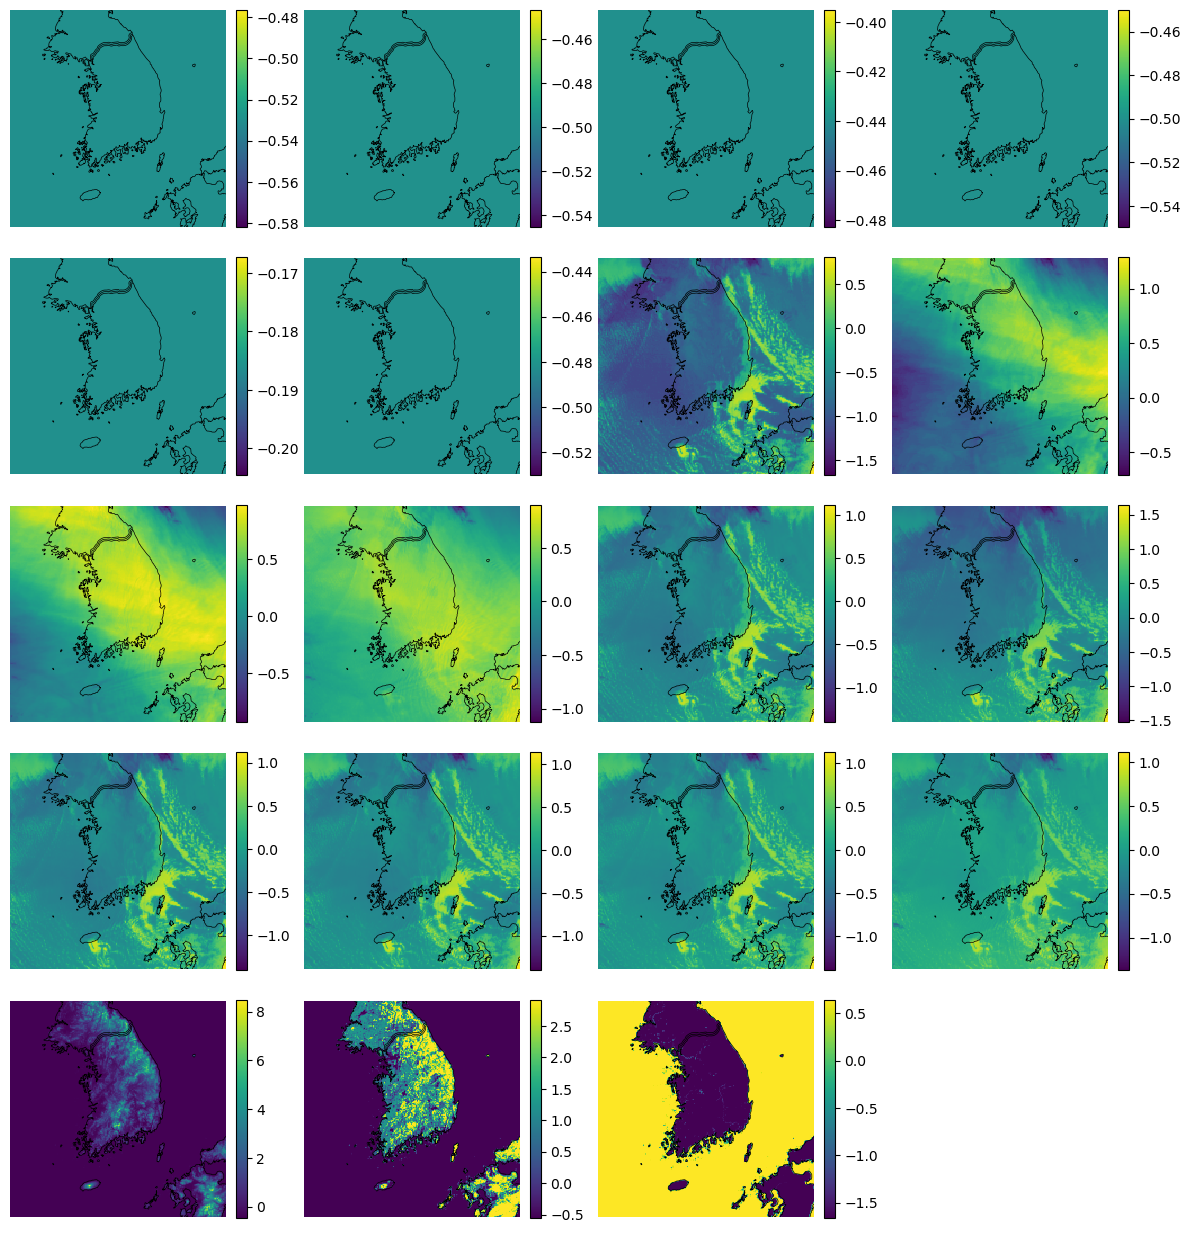

In [21]:
train_dataset.patchfy(True)
batch = train_dataset[7]
for i in range(len(batch)):
    images, label, coords = batch[i]
    print(images.shape, label.shape, coords.shape)

    fig, axs = plt.subplots(math.ceil(images.shape[0]/4), 4, figsize=(12, 2.5 * math.ceil(images.shape[0]/4)), subplot_kw={'projection': lcc})
    for i in range(len(axs.flatten())):
        ax = axs.flatten()[i]
        if i >= images.shape[0]:
            ax.axis('off')
            continue
        
        # channel = total_channels[i]
        # ax.set_title(channel)

        image = np.ones((asos_image_size, asos_image_size), dtype=np.float32)
        image *= -1.0
        image[coords[1]:coords[1]+patch_size, coords[0]:coords[0]+patch_size] = images[i].numpy()

        ax.set_aspect('equal')
        ax.axis('off')
        
        im = ax.pcolormesh(asos_lon, asos_lat, image, cmap='viridis', transform=proj)
            
        ax.coastlines(resolution='10m', color='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)

        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
    plt.tight_layout()
    plt.show()

In [ ]:
model = get_model(total_channels, patch_size, class_num=2, model_type='deeplab')
model

In [ ]:
def calc_measure_valid(Y_test, Y_test_hat, cutoff=0.5):
    Y_test = Y_test.ravel()
    Y_test_hat = Y_test_hat.ravel()
    
    Y_valid = (~np.isnan(Y_test))
    Y_test = Y_test[Y_valid]
    Y_test_hat = Y_test_hat[Y_valid]

    cfmat = confusion_matrix(Y_test, Y_test_hat > cutoff, labels = [0,1])
    acc = np.trace(cfmat) / np.sum(cfmat)
    csi = cfmat[1,1] /(np.sum(cfmat) - cfmat[0,0] + 1e-8)
    
    try:
        auroc = roc_auc_score(Y_test, Y_test_hat)
    except Exception as e:
        auroc = 0.0

    return csi, acc, auroc

In [ ]:
def train(model, images, labels, coords, map_dict, cls_num=0):
    images = images.cuda()
    labels = labels.cuda()

    pred_map = model.forward(images)[:, cls_num] # B, H, W
    pred_vec = torch.zeros_like(labels)
    for b, (px, py) in enumerate(coords):
        for i, (x, y) in enumerate(map_dict.values()):
            if px <= x < px + patch_size and py <= y < py + patch_size:
                pred_vec[b, i] = pred_map[b, y - py, x - px]
            else:
                pred_vec[b, i] = labels[b, i]

    labels_valid = (~torch.isnan(labels)).float()
    labels = torch.nan_to_num(labels, 0.0)

    loss_focal_raw = sigmoid_focal_loss(pred_vec, labels, alpha=-1, gamma=2, reduction='none')
    loss_focal = (loss_focal_raw * labels_valid).sum() / labels_valid.sum().clamp(min=1.0)
    valid_any_batch = (labels_valid.sum() > 0)
    all_zero_batch = ((labels * labels_valid).sum() == 0)
                
    if not (valid_any_batch and all_zero_batch):
        loss_non_frost = torch.tensor(0.0, device=labels.device)
    else:
        loss_non_frost = binary_cross_entropy_with_logits(
                        pred_map, torch.zeros_like(pred_map), reduction='mean'
                    )

    tp = torch.sum(torch.sigmoid(pred_vec) * labels * labels_valid, dim=0)
    fn = torch.sum((1-torch.sigmoid(pred_vec)) * labels * labels_valid, dim=0)
    fp = torch.sum(torch.sigmoid(pred_vec) * (1-labels) * labels_valid, dim=0)
                
    loss_csi = torch.mean(-torch.log(tp + 1e-10) + torch.log(tp + fn + fp + 1e-10)) # csi = tp / (tp + fn + fp)

    return loss_focal + loss_non_frost + loss_csi
    

for seed in seeds:
    if os.path.exists(f'{output_path}/{seed}/ckpt.pt'):
        print(f'Seed {seed} already done. Skipping...')
        continue
    
    model = get_model(total_channels, patch_size)
    model.cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay, gamma=lr_decay)

    start_epoch = 0
    
    results = dict(
            loss = {'asos': [], 'aafos': [], 'total': []},
            csi = {'asos': {}, 'aafos': {}},
            acc = {'asos': {}, 'aafos': {}},
            auroc = {'asos': [], 'aafos': []}, 
            
            best_asos = {},
            best_aafos = {},
            best_mean = {},
        )
    
    for cutoff_str in threshold:
        cutoff_str = str(cutoff_str)
        
        results['csi']['asos'][cutoff_str] = []
        results['acc']['asos'][cutoff_str] = []
        results['best_asos'][cutoff_str] = {'csi': 0.0, 'epoch': -1, 'model': None}
        
        results['csi']['aafos'][cutoff_str] = []
        results['acc']['aafos'][cutoff_str] = []
        results['best_aafos'][cutoff_str] = {'csi': 0.0, 'epoch': -1, 'model': None}
        
        results['best_mean'][cutoff_str] = {'csi': 0.0, 'epoch': -1, 'model': None}
    
    if os.path.exists(f'{output_path}/{seed}/resume.pt'):
        resume = torch.load(f'{output_path}/{seed}/resume.pt')
        model.load_state_dict(resume['model'])
        optimizer.load_state_dict(resume['optimizer'])
        scheduler.load_state_dict(resume['scheduler'])
        start_epoch = resume['epoch'] + 1
        results = resume['results']
        print(f'Resuming from epoch {start_epoch}...')
    
    for epoch in range(start_epoch, epochs):
        model.train()
        
        total_loss_asos = 0.0
        total_loss_aafos = 0.0
        total_loss = 0.0
                
        # asos와 aafos 데이터셋 간 길이 맞춤 / 매 epoch마다 실행
        train_dataset.sync_dataset_length()
        for batch in tqdm(train_dataloader):
            if ASOS:
                images, label, coords = batch[0]
                loss_asos = train(model, images, label, coords, asos_map_dict, cls_num=0)
            else:
                loss_asos = torch.tensor(0.0).cuda()
            
            if AAFOS:
                images, label, coords = batch[1] if ASOS else batch[0]
                loss_aafos = train(model, images, label, coords, aafos_map_dict, cls_num=1)
            else:
                loss_aafos = torch.tensor(0.0).cuda()

            loss = asos_weight * loss_asos + aafos_weight * loss_aafos
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss_asos += loss_asos.item()
            total_loss_aafos += loss_aafos.item()
            total_loss += loss.item()

        total_loss_asos = total_loss_asos / len(train_dataloader)
        total_loss_aafos = total_loss_aafos / len(train_dataloader)
        total_loss = total_loss / len(train_dataloader)

        results['loss']['asos'].append(total_loss_asos)
        results['loss']['aafos'].append(total_loss_aafos)
        results['loss']['total'].append(total_loss)

        print(f'Epoch {epoch:2d} - Total Loss: {total_loss:.4f}, ASOS Loss: {total_loss_asos:.4f}, AAFOS Loss: {total_loss_aafos:.4f}')
        # epoch loop에 있으니까 -> 10, 20 epoch마다 lr decay
        scheduler.step()
    
        model.eval()
        with torch.no_grad():
            asos_results_per_threshold = {}
            
            if ASOS:
                asos_pred_vec_list = []
                asos_labels_list = []
                for batch in test_asos_dataloader:
                    images, label, coords = batch[0]
                    images = images.cuda()
                    
                    pred_map = model.forward_by_patch(images)[:,0]
                    pred_map = F.sigmoid(pred_map)
                    
                    pred_vec = []
                    for x, y in asos_map_dict.values():
                        pred_vec.append(pred_map[:, y, x])
                    pred_vec = torch.stack(pred_vec, dim=1)
                    
                    asos_pred_vec_list.append(pred_vec.cpu().numpy())
                    asos_labels_list.append(label.numpy())
                    
                pred_vecs = np.concatenate(asos_pred_vec_list, axis=0)
                labels = np.concatenate(asos_labels_list, axis=0)
                
                for cutoff in threshold:
                    asos_result = calc_measure_valid(labels, pred_vecs, cutoff=cutoff)
                    csi, acc, auroc = asos_result[0], asos_result[1], asos_result[2]

                    cutoff_str = str(cutoff)
                    
                    results['csi']['asos'][cutoff_str].append(csi)
                    results['acc']['asos'][cutoff_str].append(acc)
                    
                    asos_results_per_threshold[cutoff_str] = asos_result
                    
                    is_best = csi > results['best_asos'][cutoff_str]['csi']
                    print(f'\t - ASOS  (T={cutoff:.2f}): CSI {csi:.4f}, AUROC {auroc:.4f} {"*" if is_best else ""}')
                    
                    if is_best:
                        results['best_asos'][cutoff_str]['csi'] = csi
                        results['best_asos'][cutoff_str]['epoch'] = epoch
                        results['best_asos'][cutoff_str]['model'] = model.state_dict()

                    asos_land_result = calc_measure_valid(labels[:,:11], pred_vecs[:,:11], cutoff=cutoff)
                    asos_coast_result = calc_measure_valid(labels[:,11:], pred_vecs[:,11:], cutoff=cutoff)
                    print(f'\t   - ASOS Land: CSI {asos_land_result[0]:.4f}, AUROC {asos_land_result[2]:.4f}')
                    print(f'\t   - ASOS Coast: CSI {asos_coast_result[0]:.4f}, AUROC {asos_coast_result[2]:.4f}')

                    log_dir = f'{output_path}/{seed}'
                    log_path = f'{log_dir}/train_log.csv'
                    
                    # 2. 폴더가 없으면 먼저 생성 (이 부분이 추가됨)
                    os.makedirs(log_dir, exist_ok=True)
                    
                    # 3. 파일 기록
                    is_first_write = not os.path.exists(log_path)
                    
                    with open(log_path, 'a') as log_f:
                        if is_first_write:
                            log_f.write('Epoch,Threshold,ASOS_Loss,CSI,AUROC,Land_CSI,Coast_CSI\n')
                        
                        log_line = (f'{epoch},{cutoff},{total_loss_asos:.6f},{csi:.6f},{auroc:.6f},'
                                    f'{asos_land_result[0]:.6f},{asos_coast_result[0]:.6f}\n')
                        log_f.write(log_line)

                results['auroc']['asos'].append(auroc)
                            
            print()
        
        resume = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'epoch': epoch,
            'results': results
        }
        os.makedirs(f'{output_path}/{seed}', exist_ok=True)
        torch.save(resume, f'{output_path}/{seed}/resume.pt')
    
    torch.save(results, f'{output_path}/{seed}/ckpt.pt')
    os.remove(f'{output_path}/{seed}/resume.pt')

In [ ]:
if ASOS and not AAFOS:
    mode = 'best_asos'

results_df = pd.DataFrame(columns=['type','cutoff','label', 'csi', 'acc', 'auroc'])

results_dict = {}
for cutoff in threshold:
    results_dict[str(cutoff)] = {
        'asos': {},
        'aafos': {}
    }

for seed in seeds:
    ckpt_path = f'{output_path}/{seed}/ckpt.pt'
    if not os.path.exists(ckpt_path):
        print(f'Seed {seed} not found. Skipping...')
        continue
    
    ckpt = torch.load(ckpt_path)
    print(f'--- Processing Seed {seed} ({ckpt_path}) ---')

    model = get_model(total_channels, patch_size)
    model.cuda()
    
    for cutoff in threshold:
        cutoff_str = str(cutoff)
        
        if cutoff_str not in ckpt[mode]:
            print(f"  Warning: T={cutoff_str} not found for mode '{mode}' in seed {seed}. Skipping.")
            continue
            
        try:
            model_data = ckpt[mode][cutoff_str]
            model.load_state_dict(model_data['model'])
            model.eval()
            print(f"  T={cutoff_str}: Loaded epoch {model_data['epoch']} with {mode} CSI {model_data['csi']:.4f}")
        except Exception as e:
            print(f"  Error loading model for T={cutoff_str}, Seed={seed}: {e}. Skipping.")
            continue
        
        
        with torch.no_grad():
            if ASOS:
                asos_pred_vec_list = []
                asos_labels_list = []
                
                for batch in tqdm(test_asos_dataloader, desc=f"ASOS Eval (Seed {seed}, T={cutoff_str})"):
                    images, label, coords = batch[0]
                    images = images.cuda()
                    
                    pred_map = model.forward_by_patch(images)[:,0]
                    pred_map = F.sigmoid(pred_map)
                    
                    pred_vec = []
                    for x, y in asos_map_dict.values():
                        pred_vec.append(pred_map[:, y, x])
                    pred_vec = torch.stack(pred_vec, dim=1)
                    
                    asos_pred_vec_list.append(pred_vec.cpu().numpy())
                    asos_labels_list.append(label.numpy())
                        
                pred_vecs = np.concatenate(asos_pred_vec_list, axis=0)
                labels = np.concatenate(asos_labels_list, axis=0)
                
                label_cols = [col for _, col in test_asos_data_info_list[0]['hour_col_pairs']]
                for col in label_cols:
                    indices = [i for i, data_dict in enumerate(test_asos_dataset.data_info_list[0]['data_dict_list']) if data_dict['label_col'] == col]
                    pred_vec_selected = pred_vecs[indices]
                    labels_selected = labels[indices]
                    
                    results = calc_measure_valid(labels_selected, pred_vec_selected, cutoff=cutoff)
                    
                    results_dict[cutoff_str]['asos'].setdefault(col, {})
                    results_dict[cutoff_str]['asos'][col].setdefault('csi', []).append(results[0])
                    results_dict[cutoff_str]['asos'][col].setdefault('acc', []).append(results[1])
                    results_dict[cutoff_str]['asos'][col].setdefault('auroc', []).append(results[2])


all_results_rows = []

for cutoff_str, type_dict_for_thr in results_dict.items():
    for data_type, type_dict in type_dict_for_thr.items():
        csi_mean_list = []
        acc_mean_list = []
        auroc_mean_list = []
        
        for label_col, metrics_dict in type_dict.items():
            
            if not metrics_dict.get('csi'):
                print(f"Warning: No data found for T={cutoff_str}, Type={data_type}, Label={label_col}. Skipping row.")
                continue

            csi_mean = np.mean(metrics_dict['csi'])
            csi_mean_list.append(csi_mean)
            csi_std = np.std(metrics_dict['csi'])
            
            acc_mean = np.mean(metrics_dict['acc']) 
            acc_mean_list.append(acc_mean)
            acc_std = np.std(metrics_dict['acc'])
            
            auroc_mean = np.mean(metrics_dict['auroc'])
            auroc_mean_list.append(auroc_mean)
            auroc_std = np.std(metrics_dict['auroc'])

            all_results_rows.append({
                'type': data_type,
                'threshold': cutoff_str,  
                'label': label_col,
                'csi': f'{csi_mean:.4f}',
                'acc': f'{acc_mean:.4f}',
                'auroc': f'{auroc_mean:.4f}',
            })
            
        all_results_rows.append({
            'type': data_type,
            'threshold': cutoff_str,
            'label': 'mean',
            'csi': f'{np.mean(csi_mean_list):.4f}',
            'acc': f'{np.mean(acc_mean_list):.4f}',
            'auroc': f'{np.mean(auroc_mean_list):.4f}',
        })


if all_results_rows:
    results_df = pd.DataFrame(all_results_rows)
else:
    print("Warning: No results were generated.")
print(results_df) 

output_csv_path = f'{output_path}/final_results_{mode}.csv'
results_df.to_csv(output_csv_path, index=False)
print(f"\nFinal results saved to {output_csv_path}")

In [ ]:
water_map = np.load('./assets/misc_channels/watermap_1km_avg_1800.npy')
water_map = cv2.resize(water_map, (image_size, image_size), interpolation=cv2.INTER_CUBIC)
water_mask = -1.0 * water_map + 1.0
print(water_mask.shape)